In [ ]:
# Load the Drive helper and mount
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


In [ ]:
#Importing few libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [ ]:
file_path="/content/drive/My Drive/Oranized_IQ_NCCD_Luns_cancer_dataset/"

In [ ]:
os.listdir(file_path)

['test', 'val', 'train']

In [ ]:
#making train,test and calidation path
train_path= file_path + "/train/"
test_path=file_path + "/test/"
val_path= file_path + "/val/"

In [ ]:
print(f"total number of dataset for training malignant is:{len(os.listdir(train_path + 'Malignant cases'))}")
print(f"total number of dataset for testing malignant is:{len(os.listdir(test_path + 'Malignant cases'))}")
print(f"total number of dataset for validation malignant is:{len(os.listdir(val_path + 'Malignant cases'))}")
print(f"total number of dataset for training benign is:{len(os.listdir(train_path + 'Bengin cases'))}")
print(f"total number of dataset for testing benign is:{len(os.listdir(test_path + 'Bengin cases'))}")
print(f"total number of dataset for validation benign is:{len(os.listdir(val_path + 'Bengin cases'))}")

total number of dataset for training malignant is:392
total number of dataset for testing malignant is:57
total number of dataset for validation malignant is:112
total number of dataset for training benign is:375
total number of dataset for testing benign is:54
total number of dataset for validation benign is:107


In [ ]:
os.listdir(train_path + 'Malignant cases')[6]

'Malignant case (107).jpg'

In [ ]:

#viewing the image
single_malignat_case=train_path + 'Malignant cases/' + 'Malignant case (107).jpg'

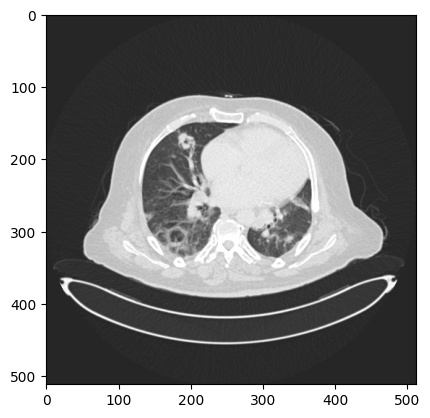

In [ ]:
mal_img=imread(single_malignat_case)
plt.imshow(mal_img)

# DATA PREPROCESSING

In [ ]:
#checking the dimension of the dataset
dim1=[]
dim2=[]
col=[]
for i in os.listdir(test_path + "Malignant cases"):
    img_read=imread(test_path + "Malignant cases/" + i)
    d1,d2,colors=img_read.shape
    dim1.append(d1)
    dim2.append(d2)
    col.append(colors)

In [ ]:
print(np.mean(dim1))
print(np.mean(dim2))
print(np.mean(col))

512.0
531.1052631578947
3.0


In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_to_numpy(path, image_size=(256, 256), batch_size=32):
    # Initialize the ImageDataGenerator without augmentation
    datagen = ImageDataGenerator(rescale=1./255)  # Rescaling images

    # Creating a generator
    generator = datagen.flow_from_directory(
        path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary'
    )


    num_images = generator.samples

    # Initialize arrays to hold the data and labels
    data = np.zeros((num_images, image_size[0], image_size[1], 3), dtype=np.float32)
    labels = np.zeros((num_images, 1), dtype=np.float32)  # since it is for binary classification

    # Filling the data and labels arrays
    i = 0
    for x_batch, y_batch in generator:
        batch_size = x_batch.shape[0]
        data[i:i+batch_size] = x_batch
        labels[i:i+batch_size] = y_batch.reshape(-1, 1)
        i += batch_size
        if i >= num_images:
            break

    return data, labels

train_data, train_labels = load_images_to_numpy(train_path)
test_data, test_labels = load_images_to_numpy(test_path)
val_data, val_labels = load_images_to_numpy(val_path)

Found 767 images belonging to 2 classes.
Found 111 images belonging to 2 classes.
Found 219 images belonging to 2 classes.


APPLYING SMOTE

For imbalanced dataset

In [ ]:
# Step 2: Applying SMOTE to the training data
smote = SMOTE()
train_data_res, train_labels_res = smote.fit_resample(train_data.reshape((-1, 256 * 256 * 3)), train_labels)
train_data_res = train_data_res.reshape((-1, 256, 256, 3))

In [ ]:
train_data_res.shape

(784, 256, 256, 3)

# MODEL DEVELOPMENT

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#Residual Block
def res_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):  # Reduced L2 regularization
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

#Covulutional Stacked Layers
inputs = Input(shape=(256, 256, 3))
x = res_block(inputs, 16)  # Reduced number of filters
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.10)(x)  # first droupout

x = res_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.15)(x) #increasing droupout

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced number of dense layer neurons
x = Dropout(0.20)(x)
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(lr=1e-4)  # Adjusted learning rate

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

ResGenRegNet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:

batch_size = 16

history = ResGenRegNet_model.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
49/49 [==============================] - 11s 55ms/step - loss: 0.8580 - accuracy: 0.8214 - val_loss: 1.2687 - val_accuracy: 0.5114 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
49/49 [==============================] - 2s 33ms/step - loss: 0.5426 - accuracy: 0.9413 - val_loss: 1.5407 - val_accuracy: 0.5114 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
49/49 [==============================] - 2s 33ms/step - loss: 0.4574 - accuracy: 0.9566 - val_loss: 0.9272 - val_accuracy: 0.5982 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
49/49 [==============================] - 2s 33ms/step - loss: 0.4206 - accuracy: 0.9515 - val_loss: 1.3527 - val_accuracy: 0.5845 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(history)

# Apply K-FOLD CROSS VALIDATION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

def res_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x


def create_model():
    inputs = Input(shape=(256, 256, 3))
    x = res_block(inputs, 16)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.10)(x)

    x = res_block(x, 32)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.15)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.20)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold = []
loss_per_fold = []
test_acc_per_fold = []

fold_no = 1
for train, val in kfold.split(train_data_res, train_labels_res):
  ResGenRegNet_cross_validation_model = create_model()
  model_checkpoint_path = f'/content/drive/My Drive/ResCovNet_Accuracy_VALIDATION_Folder/ResCovNet_model_fold_{fold_no}.h5'
  model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
  lr_callback = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch % 20 == 0 else lr, verbose=1)

  print(f'Training for fold {fold_no}...')

  history = ResGenRegNet_cross_validation_model.fit(train_data_res[train], train_labels_res[train],
                        batch_size=16,
                        epochs=100,
                        validation_data=(train_data_res[val], train_labels_res[val]),
                        callbacks=[model_checkpoint, early_stopping, reduce_lr, lr_callback])

    # Load the best model and evaluate on the test dataset
  best_model = load_model(model_checkpoint_path)
  test_scores = best_model.evaluate(test_data, test_labels, verbose=0)
  test_acc_per_fold.append(test_scores[1] * 100)

  fold_no += 1






Training for fold 1...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
40/40 [==============================] - 5s 48ms/step - loss: 0.9586 - accuracy: 0.7289 - val_loss: 1.1471 - val_accuracy: 0.5096 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
40/40 [==============================] - 1s 33ms/step - loss: 0.5881 - accuracy: 0.9266 - val_loss: 1.9020 - val_accuracy: 0.5096 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
40/40 [==============================] - 1s 34ms/step - loss: 0.4827 - accuracy: 0.9537 - val_loss: 2.6062 - val_accuracy: 0.5096 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4351 - accuracy: 0.9458 - val_loss: 2.9014 - val_accuracy: 0.5096 - lr: 9.0000e-04

Epoch 5: LearningRat

Training for fold 2...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
40/40 [==============================] - 6s 50ms/step - loss: 0.9324 - accuracy: 0.7943 - val_loss: 1.1307 - val_accuracy: 0.4586 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
40/40 [==============================] - 1s 34ms/step - loss: 0.6036 - accuracy: 0.9266 - val_loss: 1.7061 - val_accuracy: 0.4586 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
40/40 [==============================] - 1s 35ms/step - loss: 0.5037 - accuracy: 0.9330 - val_loss: 2.9216 - val_accuracy: 0.4586 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4959 - accuracy: 0.9234 - val_loss: 2.7517 - val_accuracy: 0.4586 - lr: 9.0000e-04

Epoch 5: LearningRat

Training for fold 3...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
40/40 [==============================] - 5s 50ms/step - loss: 0.9072 - accuracy: 0.8038 - val_loss: 1.0952 - val_accuracy: 0.5541 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
40/40 [==============================] - 1s 34ms/step - loss: 0.5884 - accuracy: 0.9250 - val_loss: 1.7029 - val_accuracy: 0.5287 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
40/40 [==============================] - 1s 34ms/step - loss: 0.5182 - accuracy: 0.9282 - val_loss: 1.9022 - val_accuracy: 0.5287 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
40/40 [==============================] - 1s 36ms/step - loss: 0.4557 - accuracy: 0.9426 - val_loss: 1.3833 - val_accuracy: 0.5732 - lr: 9.0000e-04

Epoch 5: LearningRat

Training for fold 4...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
40/40 [==============================] - 5s 49ms/step - loss: 0.9634 - accuracy: 0.7592 - val_loss: 1.1018 - val_accuracy: 0.5223 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
40/40 [==============================] - 1s 33ms/step - loss: 0.5953 - accuracy: 0.9394 - val_loss: 1.2600 - val_accuracy: 0.4713 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
40/40 [==============================] - 1s 33ms/step - loss: 0.5222 - accuracy: 0.9410 - val_loss: 2.1675 - val_accuracy: 0.4713 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4889 - accuracy: 0.9362 - val_loss: 2.2457 - val_accuracy: 0.4713 - lr: 9.0000e-04

Epoch 5: LearningRat

Training for fold 5...

Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/100
40/40 [==============================] - 5s 49ms/step - loss: 0.9359 - accuracy: 0.7691 - val_loss: 1.1470 - val_accuracy: 0.5321 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/100
40/40 [==============================] - 1s 33ms/step - loss: 0.6015 - accuracy: 0.9188 - val_loss: 1.9934 - val_accuracy: 0.5321 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/100
40/40 [==============================] - 1s 34ms/step - loss: 0.5220 - accuracy: 0.9315 - val_loss: 2.5622 - val_accuracy: 0.5321 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 4/100
40/40 [==============================] - 1s 33ms/step - loss: 0.4422 - accuracy: 0.9586 - val_loss: 2.7172 - val_accuracy: 0.5321 - lr: 9.0000e-04

Epoch 5: LearningRat

In [ ]:
# Select the best model based on test dataset accuracy
best_fold_index = np.argmax(test_acc_per_fold)
print(f'Best model is from fold {best_fold_index + 1} with test accuracy of {test_acc_per_fold[best_fold_index]:.2f}%')

Best model is from fold 2 with test accuracy of 98.20%


In [ ]:
ResGenRegNet_cross_validation_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_124 (Conv2D)         (None, 256, 256, 16)         448       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_84 (Ba  (None, 256, 256, 16)         64        ['conv2d_124[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_84 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_8

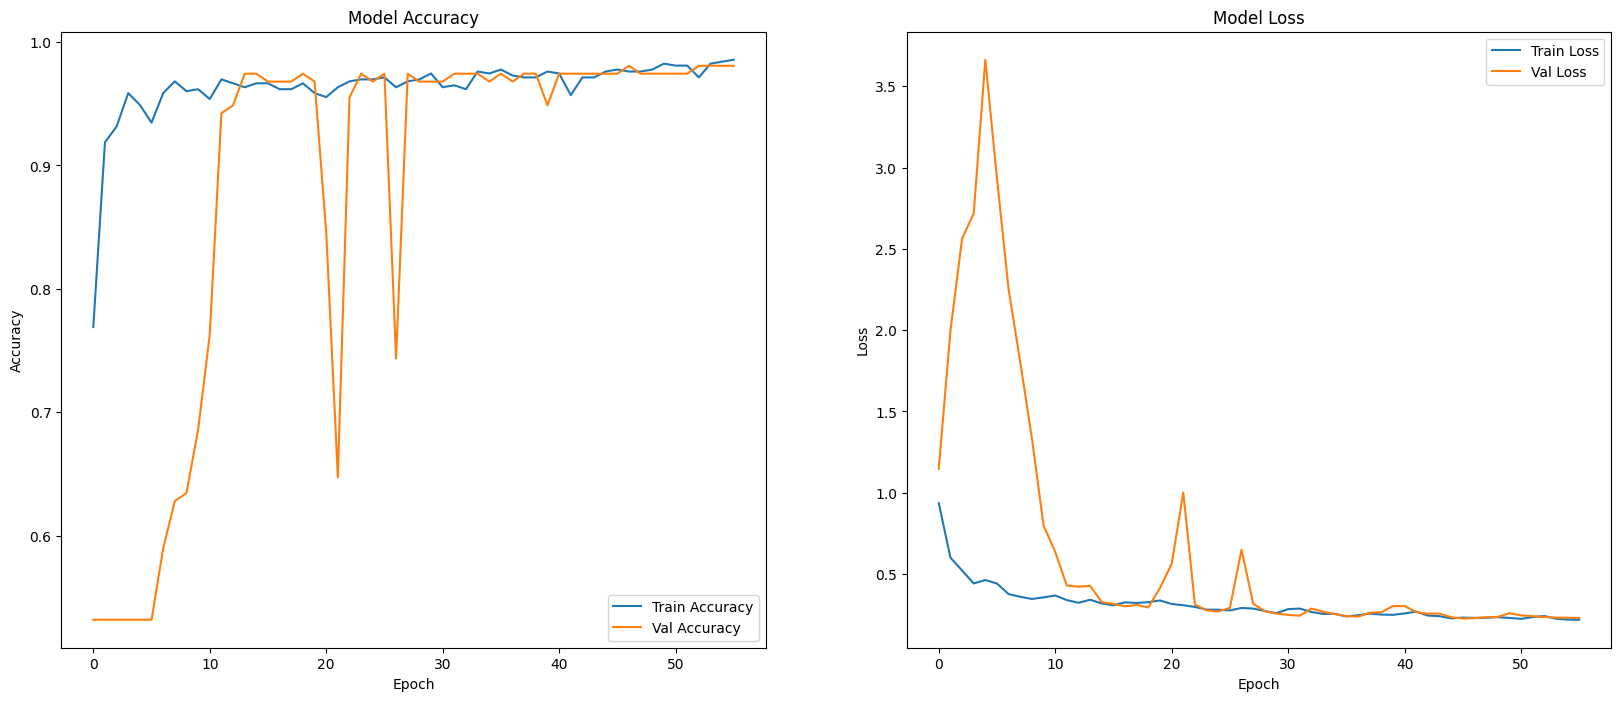

In [ ]:
# Ploting accuracy and loss for the last fold
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# printing each fold accuracy
print("Validation Accuracies per Fold:", acc_per_fold)
print("Test Accuracies per Fold:", test_acc_per_fold)

Validation Accuracies per Fold: []
Test Accuracies per Fold: [98.19819927215576, 93.69369149208069, 98.19819927215576, 98.19819927215576, 97.29729890823364]


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load the best model
best_model_path = '/content/drive/My Drive/ResCovNet_Accuracy_VALIDATION_Folder/ResCovNet_model_fold_4.h5'
best_model = load_model(best_model_path)

# Evaluating the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(test_data, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Making predictions with the best model
predictions = best_model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)


feature_model = Model(inputs=best_model.input, outputs=best_model.layers[-2].output)
features = feature_model.predict(test_data)



4/4 [==============================] - 0s 15ms/step - loss: 0.3130 - accuracy: 0.9820
Test Loss: 0.3130471408367157
Test Accuracy: 0.9819819927215576
4/4 [==============================] - 0s 10ms/step


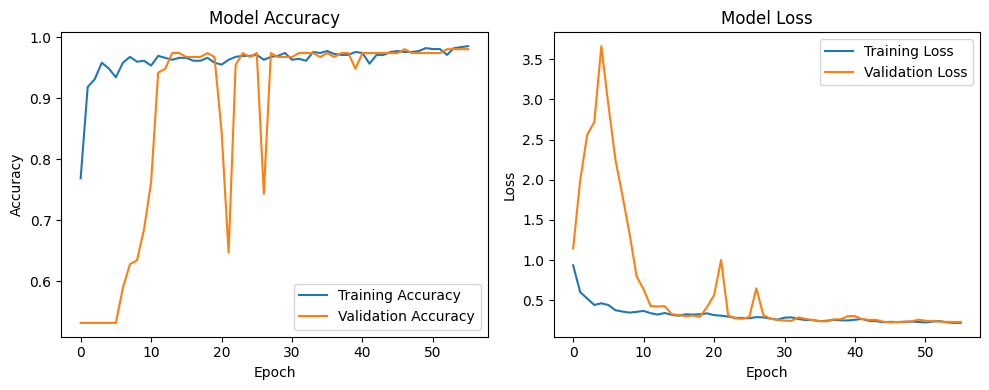

In [ ]:

# plotting code for training/validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



4/4 [==============================] - 0s 15ms/step


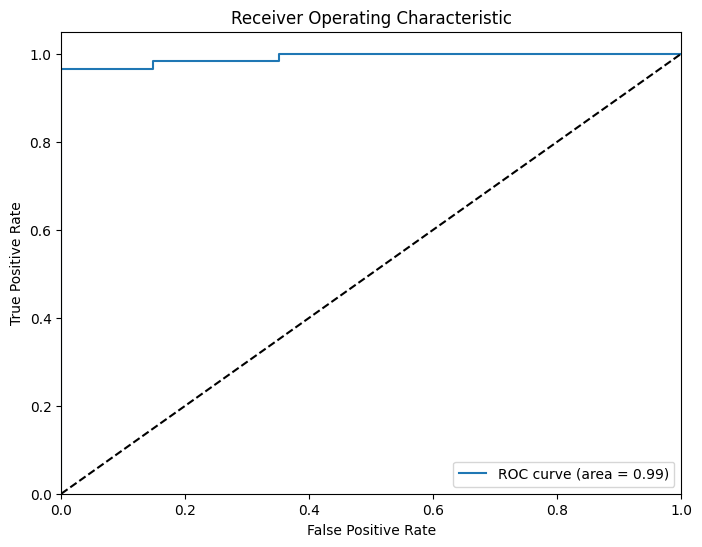

AUC:  0.9912280701754386
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        54
         1.0       1.00      0.96      0.98        57

    accuracy                           0.98       111
   macro avg       0.98      0.98      0.98       111
weighted avg       0.98      0.98      0.98       111

Confusion Matrix:
 [[54  0]
 [ 2 55]]
Sensitivity:  0.9649122807017544
Specificity:  1.0
True Negatives: 54
False Positives: 0
False Negatives: 2
True Positives: 55


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

best_model = load_model(best_model_path)
# Get the predicted probabilities
predictions = best_model.predict(test_data)

# Convert to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Calculate the AUC
auc = roc_auc_score(test_labels, predictions)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, predictions)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, predictions)

# Generate a classification report
report = classification_report(test_labels, binary_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)
tn, fp, fn, tp = cm.ravel()

# Sensitivity (recall for the positive class)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Now, plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print all the metrics
print('AUC: ', auc)
print('Classification Report:\n', report)
print('Confusion Matrix:\n', cm)
print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


# ABLATION STUDY

Witout L2 reuliraztion and Dropout

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Residual Block without L2 regularization
def res_block_no_l2(x, filters, kernel_size=(3, 3), activation='relu'):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same')(x)  # Removed L2 regularization
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)  # Removed L2 regularization
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)  # Removed L2 regularization
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

# Building the model without L2 regularization and Dropout
inputs = Input(shape=(256, 256, 3))
x = res_block_no_l2(inputs, 16)
x = MaxPooling2D((2, 2))(x)
# Dropout removed

x = res_block_no_l2(x, 32)
x = MaxPooling2D((2, 2))(x)
# Dropout removed

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Dropout removed
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model_no_l2_dropout = Model(inputs=inputs, outputs=outputs)
ResGenRegNet_model_no_l2_dropout.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


In [ ]:

batch_size = 16

history = ResGenRegNet_model_no_l2_dropout.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
49/49 [==============================] - 6s 69ms/step - loss: 0.4191 - accuracy: 0.8036 - val_loss: 0.7863 - val_accuracy: 0.5114 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
49/49 [==============================] - 3s 56ms/step - loss: 0.1552 - accuracy: 0.9541 - val_loss: 1.7532 - val_accuracy: 0.5114 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
49/49 [==============================] - 3s 56ms/step - loss: 0.1788 - accuracy: 0.9337 - val_loss: 1.6756 - val_accuracy: 0.5616 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
49/49 [==============================] - 3s 56ms/step - loss: 0.1380 - accuracy: 0.9630 - val_loss: 0.7807 - val_accuracy: 0.6575 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model_no_l2_dropout.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 38ms/step - loss: 0.0481 - accuracy: 0.9820
Test Loss: 0.048103537410497665
Test Accuracy: 0.9819819927215576


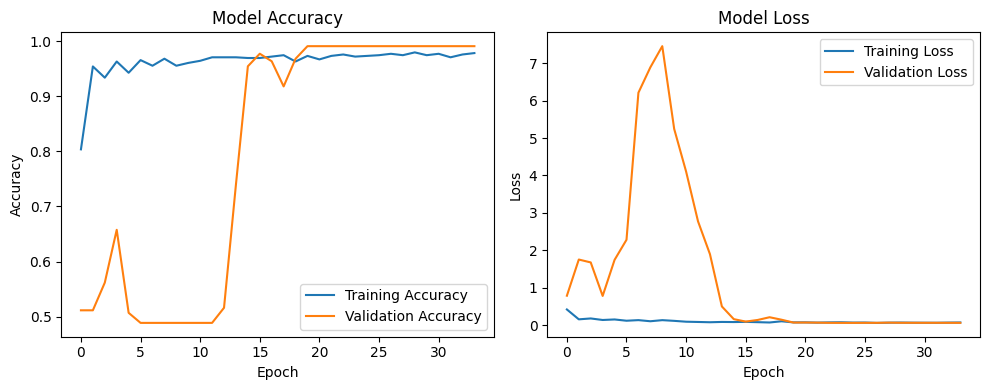

In [ ]:

#plotting code for training/validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

2. Without L2 reularization

In [ ]:
# Use the original res_block function but set l2_reg to 0.0 directly in the function definition

def res_block_no_l2(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.0):  # L2 regularization removed
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x


#Covulutional Stacked Layers
inputs = Input(shape=(256, 256, 3))
x = res_block_no_l2(inputs, 16)  # Reduced number of filters
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.10)(x)  # first droupout

x = res_block_no_l2(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.15)(x) #increasing droupout

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced number of dense layer neurons
x = Dropout(0.20)(x)
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model_no_L2 = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(lr=1e-4)  # Adjusted learning rate

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

ResGenRegNet_model_no_L2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
# Adjust the batch size according to your system's capabilities
batch_size = 16

history3 = ResGenRegNet_model_no_L2.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
49/49 [==============================] - 8s 99ms/step - loss: 0.3738 - accuracy: 0.8622 - val_loss: 0.7420 - val_accuracy: 0.5708 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
49/49 [==============================] - 4s 86ms/step - loss: 0.2082 - accuracy: 0.9145 - val_loss: 0.7580 - val_accuracy: 0.5388 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
49/49 [==============================] - 4s 86ms/step - loss: 0.1739 - accuracy: 0.9362 - val_loss: 0.8926 - val_accuracy: 0.6210 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
49/49 [==============================] - 4s 86ms/step - loss: 0.1513 - accuracy: 0.9503 - val_loss: 2.1655 - val_accuracy: 0.4886 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model_no_L2.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 29ms/step - loss: 0.7567 - accuracy: 0.5135
Test Loss: 0.7566551566123962
Test Accuracy: 0.5135135054588318


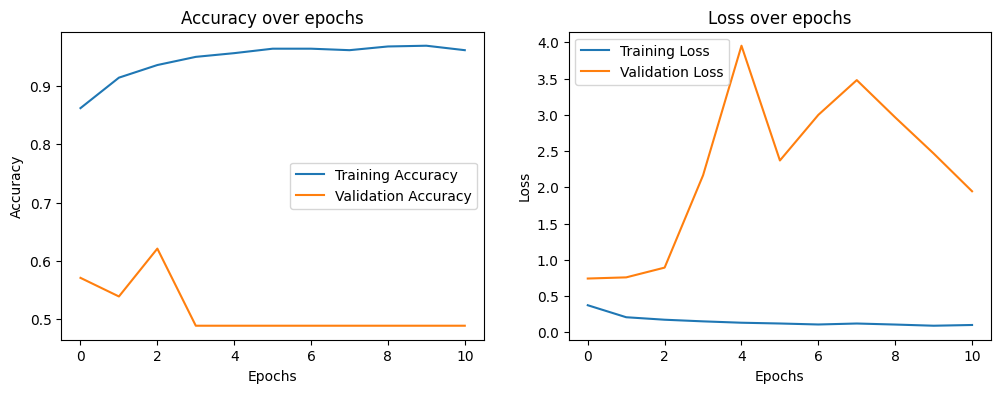

In [ ]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history3.history['accuracy'], label='Training Accuracy')
    plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history3.history['loss'], label='Training Loss')
    plt.plot(history3.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(history3)

Removing skip connections

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Convolutional Block (previously Residual Block without skip connection)
def conv_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

# Covulutional Stacked Layers
inputs = Input(shape=(256, 256, 3))
x = conv_block(inputs, 16)  # Reduced number of filters
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.10)(x)  # first dropout

x = conv_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.15)(x) #increasing dropout

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced number of dense layer neurons
x = Dropout(0.20)(x)
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model_no_skip = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(lr=1e-4)  # Adjusted learning rate

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.2
    return lr

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

ResGenRegNet_model_no_skip.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
batch_size = 16

history4 = ResGenRegNet_model_no_skip.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[lr_callback,early_stopping,reduce_lr]
)


Epoch 1: LearningRateScheduler setting learning rate to 3.200000264769187e-07.
Epoch 1/100
49/49 [==============================] - 4s 87ms/step - loss: 0.1703 - accuracy: 0.9732 - val_loss: 0.1633 - val_accuracy: 0.9909 - lr: 3.2000e-07

Epoch 2: LearningRateScheduler setting learning rate to 3.200000264769187e-07.
Epoch 2/100
49/49 [==============================] - 4s 79ms/step - loss: 0.1732 - accuracy: 0.9694 - val_loss: 0.1634 - val_accuracy: 0.9863 - lr: 3.2000e-07

Epoch 3: LearningRateScheduler setting learning rate to 3.200000264769187e-07.
Epoch 3/100
49/49 [==============================] - 4s 81ms/step - loss: 0.1729 - accuracy: 0.9719 - val_loss: 0.1635 - val_accuracy: 0.9863 - lr: 3.2000e-07

Epoch 4: LearningRateScheduler setting learning rate to 3.200000264769187e-07.
Epoch 4/100
49/49 [==============================] - 4s 81ms/step - loss: 0.1617 - accuracy: 0.9770 - val_loss: 0.1634 - val_accuracy: 0.9863 - lr: 3.2000e-07

Epoch 5: LearningRateScheduler setting lear

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model_no_skip.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 0s 31ms/step - loss: 0.1514 - accuracy: 0.9820
Test Loss: 0.15144579112529755
Test Accuracy: 0.9819819927215576


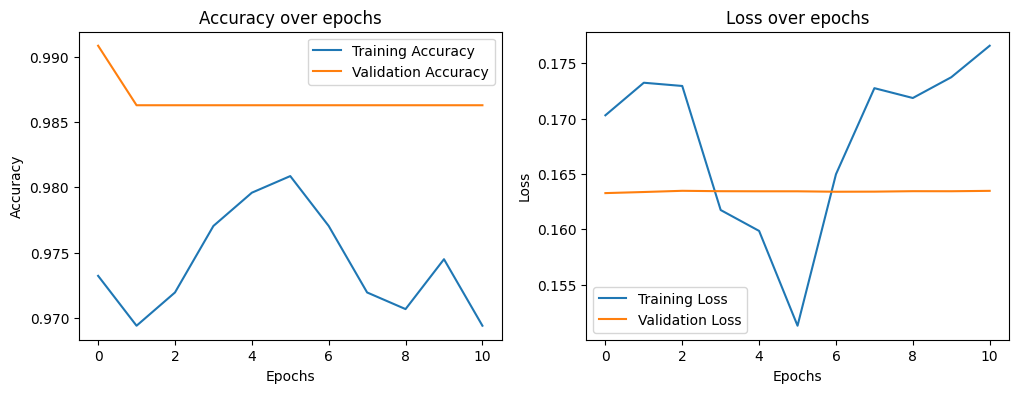

In [ ]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history4.history['accuracy'], label='Training Accuracy')
    plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history4.history['loss'], label='Training Loss')
    plt.plot(history4.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_history(history4)

without schedular

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#Residual Block
def res_block(x, filters, kernel_size=(3, 3), activation='relu', l2_reg=0.005):  # Reduced L2 regularization
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, (1, 1), padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

#Covulutional Stacked Layers
inputs = Input(shape=(256, 256, 3))
x = res_block(inputs, 16)  # Reduced number of filters
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.10)(x)  # first droupout

x = res_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.15)(x) #increasing droupout

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced number of dense layer neurons
x = Dropout(0.20)(x)
outputs = Dense(1, activation='sigmoid')(x)

ResGenRegNet_model_no_schedular = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(lr=1e-4)  # Adjusted learning rate

# # Learning rate scheduler
# def lr_scheduler(epoch, lr):
#     if epoch > 0 and epoch % 20 == 0:
#         return lr * 0.2
#     return lr

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


ResGenRegNet_model_no_schedular.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
batch_size = 16

history5 = ResGenRegNet_model_no_schedular.fit(
    train_data_res,
    train_labels_res,
    epochs=100,
    batch_size=batch_size,  # Adjust this parameter
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
49/49 [==============================] - 8s 104ms/step - loss: 0.9069 - accuracy: 0.7577 - val_loss: 1.2104 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 4s 86ms/step - loss: 0.5374 - accuracy: 0.9273 - val_loss: 2.9168 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 4s 86ms/step - loss: 0.4492 - accuracy: 0.9452 - val_loss: 3.2781 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 4s 86ms/step - loss: 0.3912 - accuracy: 0.9515 - val_loss: 4.0944 - val_accuracy: 0.5114 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 4s 86ms/step - loss: 0.3746 - accuracy: 0.9554 - val_loss: 3.0602 - val_accuracy: 0.5662 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.9566
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
49/49 [==============================] - 4s 86ms/ste

In [ ]:
import matplotlib.pyplot as plt

# Evaluating the model on the test set
test_loss, test_accuracy = ResGenRegNet_model_no_schedular.evaluate(test_data, test_labels)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 1s 64ms/step - loss: 0.1559 - accuracy: 0.9910
Test Loss: 0.15591932833194733
Test Accuracy: 0.9909909963607788


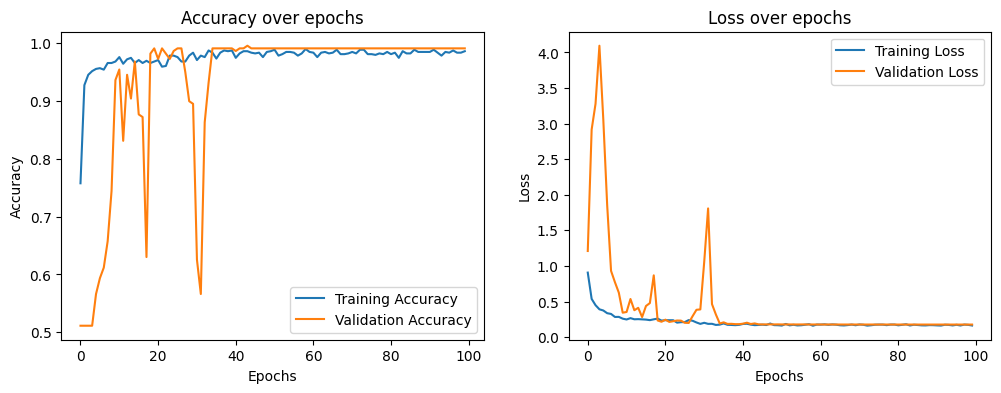

In [ ]:
# Plotting the training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history5.history['accuracy'], label='Training Accuracy')
    plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history5.history['loss'], label='Training Loss')
    plt.plot(history5.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


plot_history(history5)